In [ ]:
# here we want to test out functions for extracting features like word n-grams and phonetic char n-grams

## Word N-Grams

In [28]:
# download stopwords list
! curl -L https://raw.githubusercontent.com/gidim/HebrewStopWords/refs/heads/master/heb_stopwords.txt > heb_stopwords.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4329  100  4329    0     0  26755      0 --:--:-- --:--:-- --:--:-- 26888


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

with open('heb_stopwords.txt', 'rt') as f:
    stops = f.readlines()
    stops = [s.strip() for s in stops]


def hebrew_word_tokenizer(text):
    """
    Tokenizer function to split Hebrew text into words.
    This will capture words and also consider special characters like apostrophes.
    
    :param text: A string of Hebrew text.
    :return: A list of tokenized words.
    """
    # Regular expression to match Hebrew words, including those with apostrophes (׳)
    hebrew_word_pattern = r"\b[\u0590-\u05FF׳]+(?:-[\u0590-\u05FF׳]+)*\b"
    
    # Use re.findall to get all the words matching the pattern
    return re.findall(hebrew_word_pattern, text)

def create_tfidf_vectorizer_hebrew(texts, ngram_range=(1, 2), min_df=1, max_df=1.0):
    """
    Creates a TF-IDF feature vector of word n-grams for Hebrew text.
    
    :param texts: List of Hebrew texts (sentences or verses).
    :param ngram_range: The lower and upper boundary of the range of n-values for different n-grams (default is unigram and bigram).
    :param min_df: Minimum document frequency for the words to be considered (default=1).
    :param max_df: Maximum document frequency for the words to be considered (default=1.0, no max filter).
    :return: A sparse matrix of TF-IDF features and the corresponding feature names (n-grams).
    """
    
    # Define the vectorizer, specifying Hebrew n-grams and appropriate tokenization
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,     # N-gram range (unigram, bigram, etc.)
        min_df=min_df,               # Minimum document frequency
        max_df=max_df,               # Maximum document frequency
        strip_accents="unicode",
        tokenizer=hebrew_word_tokenizer,
        analyzer='word',             # Analyze at word-level
        stop_words=stops              # No stop words by default (can add Hebrew stop words if necessary)
    )
    
    # Fit the vectorizer on the Hebrew text and transform it into TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get the feature names (n-grams)
    feature_names = vectorizer.get_feature_names_out()
    
    return tfidf_matrix, feature_names



In [32]:
# Example usage
hebrew_texts = [
    "בְּרֵאשִׁית בָּרָא אֱלֹהִים אֵת הַשָּׁמַיִם וְאֵת הָאָרֶץ",  # Example Hebrew text (Genesis 1:1)
    "וְהָאָרֶץ הָיְתָה תֹהוּ וָבֹהוּ",  # Another verse
]

# Call the function with bigrams (ngram_range=(2, 2)) for Hebrew
tfidf_matrix, feature_names = create_tfidf_vectorizer_hebrew(hebrew_texts, ngram_range=(1, 2))

# Output the TF-IDF matrix and feature names
#print("TF-IDF Matrix:\n", tfidf_matrix.toarray())
print("Feature Names (n-grams):\n", feature_names)

Feature Names (n-grams):
 ['אלהים' 'אלהים השמים' 'ברא' 'ברא אלהים' 'בראשית' 'בראשית ברא' 'הארץ'
 'השמים' 'השמים הארץ' 'ובהו' 'והארץ' 'והארץ תהו' 'תהו' 'תהו ובהו']


/Users/hope/miniconda3/envs/babylm/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Phoneme N-grams (failed)

In [19]:
import subprocess
import re
from sklearn.feature_extraction.text import CountVectorizer

def remove_nikkud(text, keep_end=False):
    # Define the regex pattern
    if keep_end:
        return re.sub(r'[\u0591-\u05AF\u05B0-\u05BD\u05BF\u05C1-\u05C2\u05C4-\u05C7]', '', text)
    return re.sub(r'[\u0591-\u05C7]', '', text)

def get_phonetic_transcription(text):
    """
    Uses espeak to get the phonetic transcription of the Hebrew text.
    
    :param text: A string of Hebrew text.
    :return: Phonetic transcription as a string.
    """
    #text = remove_nikkud(text)
    # Use subprocess to call espeak and get phonetic transcription
    result = subprocess.run(['espeak-ng', '-v', 'he', '--ipa', text], capture_output=True, text=True)
    
    # The output from espeak
    phonetic_transcription = result.stdout.strip()
    print(text)
    return phonetic_transcription
    # Remove non-IPA characters and clean up the transcription
    #cleaned_transcription = re.sub(r'[^a-zA-Zˈˌ]+', ' ', phonetic_transcription)
    
    #return cleaned_transcription

def create_phonetic_ngrams(texts, ngram_range=(1, 2)):
    """
    Creates phonetic n-gram features from a list of Hebrew texts.
    
    :param texts: List of Hebrew texts (sentences or verses).
    :param ngram_range: The lower and upper boundary of the range of n-values for different n-grams (default is unigram and bigram).
    :return: A sparse matrix of phonetic n-grams and the corresponding feature names.
    """
    
    # List to hold phonetic transcriptions
    phonetic_texts = []
    
    # Loop through the Hebrew texts and get phonetic transcriptions
    for text in texts:
        phonetic_transcription = get_phonetic_transcription(text)
        phonetic_texts.append(phonetic_transcription)
    
    # Use CountVectorizer to extract phonetic n-grams
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,  # N-gram range (unigram, bigram, etc.)
        analyzer='char',          # Analyze at the character level (for phonetic symbols)
        min_df=1                  # Minimum document frequency
    )
    
    # Fit the vectorizer on the phonetic transcriptions
    phonetic_ngrams = vectorizer.fit_transform(phonetic_texts)
    
    # Get the feature names (phonetic n-grams)
    feature_names = vectorizer.get_feature_names_out()
    
    return phonetic_ngrams, feature_names

# Example usage
hebrew_texts = [
    "בְּרֵאשִׁית בָּרָא אֱלֹהִים",
    "וְהָאָרֶץ הָיְתָה תֹהוּ וָבֹהוּ"
]

# Call the function to create phonetic bigrams (ngram_range=(1, 2)) for Hebrew
phonetic_ngrams, feature_names = create_phonetic_ngrams(hebrew_texts, ngram_range=(3, 5))

# Output the phonetic n-gram matrix and feature names
#print("Phonetic N-grams Matrix:\n", phonetic_ngrams.toarray())
print("Feature Names (phonetic n-grams):\n", feature_names)


בְּרֵאשִׁית בָּרָא אֱלֹהִים
וְהָאָרֶץ הָיְתָה תֹהוּ וָבֹהוּ
Feature Names (phonetic n-grams):
 [' (e' ' (en' ' (en)' ' hˈ' ' hˈe' ' hˈe ' ' hˈi' ' hˈiː' ' jˈ' ' jˈo'
 ' jˈod' ' lˈ' ' lˈa' ' lˈam' ' mˈ' ' mˈe' ' mˈem' ' vˈ' ' vˈa' ' vˈav'
 ' vˈe' ' vˈet' ' ʁˈ' ' ʁˈe' ' ʁˈeʃ' ' ʃ ' ' ʃ ˈ' ' ʃ ˈi' ' ˈa' ' ˈa '
 ' ˈa (' ' ˈa v' ' ˈa ˈ' ' ˈaj' ' ˈajt' ' ˈal' ' ˈale' ' ˈe' ' ˈe '
 ' ˈe ˈ' ' ˈi' ' ˈi ' ' ˈi (' ' ˈi j' ' θˈ' ' θˈa' ' θˈav' '(en' '(en)'
 '(en)h' '(he' '(he)' '(he) ' ') h' ') hˈ' ') hˈe' ') j' ') jˈ' ') jˈo'
 ') l' ') lˈ' ') lˈa' ') v' ') vˈ' ') vˈa' ') ʁ' ') ʁˈ' ') ʁˈe' ')hˈ'
 ')hˈi' ')hˈiː' 'a (' 'a (e' 'a (en' 'a v' 'a vˈ' 'a vˈe' 'a ˈ' 'a ˈa'
 'a ˈal' 'ajt' 'ajta' 'ajtaʔ' 'ale' 'alef' 'alefʔ' 'ame' 'amed' 'amed '
 'av ' 'av (' 'av (e' 'av v' 'av vˈ' 'av ˈ' 'av ˈa' 'aɡɛ' 'aɡɛʃ' 'aɡɛʃ('
 'aʔ ' 'aʔ θ' 'aʔ θˈ' 'aˈo' 'aˈoʁ' 'aˈoʁe' 'bɹu' 'bɹuː' 'bɹuːd' 'bɹuːʃ'
 'bɹuːˈ' 'd (' 'd (e' 'd (en' 'd m' 'd mˈ' 'd mˈe' 'd θ' 'd θˈ' 'd θˈa'
 'dɒt' 'dɒt(' 'dɒt(h' 'dˈa' 'dˈaɡ' 'dˈaɡɛ' 'e v' 

In [25]:
get_phonetic_transcription(hebrew_texts[0])

בְּרֵאשִׁית בָּרָא אֱלֹהִים


'vˈet (en)hˈiːbɹuːʃvˈɑː hˈiːbɹuːdˈaɡɛʃ(he) ʁˈeʃ ˈe ˈalefʔ ʃ ˈi (en)hˈiːbɹuːʃˈɪndɒt(he) jˈod θˈav vˈet ˈa (en)hˈiːbɹuːdˈaɡɛʃ(he) ʁˈeʃ ˈa ˈalefʔ ˈalefʔ (en)hˈiːbɹuːˈɛ(he) lˈamed (en)hˈiːbɹuːˈo(he) hˈe ˈi jˈod mˈem'

In [27]:
subprocess.run(['espeak-ng', '-v', 'he', '--ipa', remove_nikkud('בְּ')], capture_output=True, text=True)

CompletedProcess(args=['espeak-ng', '-v', 'he', '--ipa', 'ב'], returncode=0, stdout='vˈet\n', stderr='')

## Neural Embeddings (already done)

In [50]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-small')
#encs = model.encode(df['line'].tolist(), show_progress_bar=True)

/Users/hope/miniconda3/envs/babylm/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# Feature Extraction

In [451]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

# Custom transformer for neural embeddings
class NeuralEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self
        

    def transform(self, X):
        self.embeddings = model.encode(X, show_progress_bar=True)
        return self.embeddings

In [671]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import normalize

def get_feature_matrix(texts: list, model, features: list):
    ngrams = TfidfVectorizer(
        ngram_range=(1,3),     # N-gram range (unigram, bigram, etc.)
        min_df=1,               # Minimum document frequency
        max_df=1.0,               # Maximum document frequency
        strip_accents="unicode",
        tokenizer=hebrew_word_tokenizer,
        analyzer='word',             # Analyze at word-level
        stop_words=stops,              # No stop words by default (can add Hebrew stop words if necessary)
        max_features= 2000
    )

     #Step 3: Dimensionality reduction with TruncatedSVD for TF-IDF (Sparse)
    svd = TruncatedSVD(n_components=10)
 
    # Create a FeatureUnion to combine the n-gram features and neural embeddings
    feats = []
    if 'ngram' in features:
        feats.append(('ngram', Pipeline([
            ('tfidf', ngrams),
            # ('svd', svd)
        ])))
    if 'neural' in features:
        feats.append(('neural_embeddings', Pipeline([
        ('embed', NeuralEmbeddingTransformer(model=model)),  # Custom embedding transformer
        ('scaler', StandardScaler())  # Step 6: Scale neural embeddings
        ])))

    
    assert len(feats) > 0, "There must be at least one feature set"
    
    combined_features = FeatureUnion(feats)

    # Transform to get the combined feature matrix
    combined_matrix = combined_features.fit_transform(texts)
    print(combined_features.get_feature_names_out().todense())

    # Normalize the combined features
    combined_matrix = normalize(combined_matrix)
    return combined_matrix

In [663]:
hebrew_texts = [
    "בְּרֵאשִׁית בָּרָא אֱלֹהִים אֵת הַשָּׁמַיִם וְאֵת הָאָרֶץ",  # Example Hebrew text (Genesis 1:1)
    "וְהָאָרֶץ הָיְתָה תֹהוּ וָבֹהוּ",  # Another verse
]

In [670]:
get_feature_matrix(hebrew_texts, None, features=['ngram'])

['ngram__אלהים' 'ngram__אלהים השמים' 'ngram__אלהים השמים הארץ'
 'ngram__ברא' 'ngram__ברא אלהים' 'ngram__ברא אלהים השמים' 'ngram__בראשית'
 'ngram__בראשית ברא' 'ngram__בראשית ברא אלהים' 'ngram__הארץ'
 'ngram__השמים' 'ngram__השמים הארץ' 'ngram__ובהו' 'ngram__והארץ'
 'ngram__והארץ תהו' 'ngram__והארץ תהו ובהו' 'ngram__תהו' 'ngram__תהו ובהו']


/Users/hope/miniconda3/envs/babylm/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<2x18 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [70]:

clean_texts = [remove_nikkud(t) for t in hebrew_texts]
neural_feats = NeuralEmbeddingTransformer(model)
embs = neural_feats.fit(clean_texts)
embs2 = neural_feats.fit_transform(clean_texts)

Batches: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


In [672]:
get_feature_matrix(clean_texts, model, ngram=True).shape

TypeError: get_feature_matrix() got an unexpected keyword argument 'ngram'

In [ ]:
# if I change to do the Bible all at once, what changes?
# I need to group them still, but don't allow groups to go over book lines. I think chapter lines are okay
# Then I think that's it. 

In [ ]:
# STEPS:
# 0. choose a book (let's go Genesis for now)
# 1. group texts given a level (includes cleaning)
# 2. extract features
# 3. compute observed chiasm score
# 4. shuffle verses and compute null score
# 5. significance testing.

In [1]:
# -1. load data
import json
with open('../data/STEP/OT_aligned_sep.json', 'rt', encoding='utf-8') as ifd:
    data = []
    for line in ifd:
        data.append(json.loads(line))

# 0. separate into books
books = {}
for line in data:
    book = line['heb_ref'].split('.')[0]
    if book not in books:
        books[book] = [line]
    else:
        books[book].append(line)


In [494]:
# # saving books individually as jsonl
# for name, book in books.items():
#     with open(f"data/{name}.jsonl", "wt") as f:
#         for line in book:
#             f.write(json.dumps(line, ensure_ascii=False) + "\n")

In [30]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class Location(dotdict):
    def __init__(self, location_str):
        parts = location_str.split('.')
        self['book'] = parts[0]
        self['chapter'] = int(parts[1])
        self['verse'] = int(parts[2])

    def __str__(self):
        return f"{self.book}.{self.chaper}.{self.verse}"
    def __hash__(self):
        return hash(repr(self))


In [16]:
import pandas as pd
df = pd.DataFrame.from_records(books['Gen'])
texts = df['line'].tolist()
translations = df['translation'].tolist()
locs = [Location(x) for x in df['heb_ref'].tolist()]
data = list(zip(locs, texts))

In [27]:
Location('Gen.1.1')

{'book': 'Gen', 'chapter': 1, 'verse': 1}

In [635]:
# 1. group verses, I want paragraphs here, so pesucha
# let's think about this. I have a list of line-level texts, and I have their index. I want to create a list of lists of which verses are in that list
groups, indices = group_verses(data, group_type='pesucha')
groups[:4], len(groups)

(['ב ראשית ברא אלהים את ה שמים ו את ה ארץ ׃ו ה ארץ היתה תהו ו בהו ו חשך על ־ פני תהום ו רוח אלהים מרחפת על ־ פני ה מים ׃ו יאמר אלהים יהי אור ו יהי ־ אור ׃ו ירא אלהים את ־ ה אור כי ־ טוב ו יבדל אלהים בין ה אור ו בין ה חשך ׃ו יקרא אלהים ׀ ל אור יום ו ל חשך קרא לילה ו יהי ־ ערב ו יהי ־ בקר יום אחד ׃',
  'ו יאמר אלהים יהי רקיע ב תוך ה מים ו יהי מבדיל בין מים ל מים ׃ו יעש אלהים את ־ ה רקיע ו יבדל בין ה מים אשר מ תחת ל רקיע ו בין ה מים אשר מ על ל רקיע ו יהי ־ כן ׃ו יקרא אלהים ל רקיע שמים ו יהי ־ ערב ו יהי ־ בקר יום שני ׃',
  'ו יאמר אלהים יקוו ה מים מ תחת ה שמים אל ־ מקום אחד ו תראה ה יבשה ו יהי ־ כן ׃ו יקרא אלהים ׀ ל יבשה ארץ ו ל מקוה ה מים קרא ימים ו ירא אלהים כי ־ טוב ׃ו יאמר אלהים תדשא ה ארץ דשא עשב מזריע זרע עץ פרי עשה פרי ל מינ ו אשר זרע ו ־ ב ו על ־ ה ארץ ו יהי ־ כן ׃ו תוצא ה ארץ דשא עשב מזריע זרע ל מינ הו ו עץ עשה ־ פרי אשר זרע ו ־ ב ו ל מינ הו ו ירא אלהים כי ־ טוב ׃ו יהי ־ ערב ו יהי ־ בקר יום שלישי ׃',
  'ו יאמר אלהים יהי מארת ב רקיע ה שמים ל הבדיל בין ה יום ו בין ה לילה ו היו ל אתת

In [636]:
indices[:4]

[[0, 1, 2, 3, 4], [5, 6, 7], [8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18]]

In [637]:
# 2. extract features 
feats = get_feature_matrix(groups, model,['ngram'])

/Users/hope/miniconda3/envs/babylm/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [638]:
feats.shape

(41, 41)

In [639]:
# 3. compute observed score
N = 4
cos_sim = cosine_similarity(feats, feats)
os = []
for i in range(len(groups)-N):
    os.append(get_chiasm_score(cos_sim, i, n=N))


In [640]:
len(os), len(groups)-N

(37, 37)

I'm wondering if this method is good but I need better randomized samples? What I've tried is taking 1000 random samples, not by shuffling, but by establishing a random baseline. 

In [460]:
import sklearn
# shuffle the feature matrix
rand_feats = sklearn.utils.shuffle(feats)

In [484]:
# 4. compute null score
import random
ns = []
n_cos_sim = cosine_similarity(feats, feats)
num_trials = 1_000
for _ in range(num_trials):
    ns.append(get_chiasm_score(n_cos_sim, random.choice(range(len(groups)-N)), n=N))
ns = np.array(ns)

In [485]:
ns.shape

(1000,)

<Axes: >

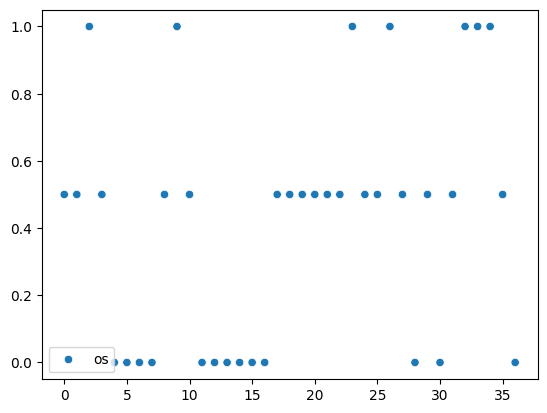

In [641]:
sns.scatterplot({'os': os,}) #'CI': [upper]*len(os)})

In [621]:
def bootstrap_confidence_intervals(data, n_samples=10000, ci_level=0.95):
    n = len(data)
    bootstrap_means = np.empty(n_samples)

    for i in range(n_samples):
        # Sample with replacement
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        # Calculate the statistic (e.g., mean)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate confidence intervals
    lower_bound = np.percentile(bootstrap_means, (1 - ci_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_means, (1 + ci_level) / 2 * 100)

    return lower_bound, upper_bound

lower, upper = bootstrap_confidence_intervals(os)
lower, upper

(0.07082551594746717, 0.09568480300187618)

In [622]:
sum(os>upper)/len(os)

0.14821763602251406

<Axes: ylabel='Count'>

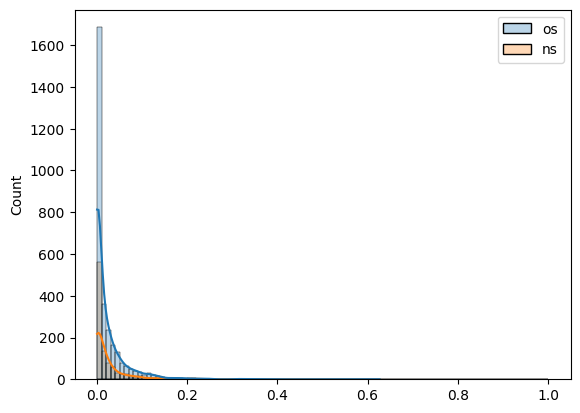

In [486]:
sns.histplot({'os': os, 'ns': ns}, color=['r','b'], alpha=0.3, binrange=(0, 1), binwidth=0.01, kde=True)

In [656]:
ss_chiasms = []
for i, o in enumerate(os):
    # if the percentage of >50% of the lines are similar enough
    if o > 0.5:
        refs=[]
        text = []
        heb_text = []
        print(indices[i:i+N])
        for line in indices[i:i+N]:
            if type(line[0]) == str:
                # then we know it's a half-verse processing
                for idx in line:
                    if 'a' in idx:
                        refs.append(df['heb_ref'].tolist()[int(idx[:-1])])
                        text.append(df['trans_a'].tolist()[int(idx[:-1])])
                        heb_text.append(df['half_a'].tolist()[int(idx[:-1])])
                    elif 'b' in idx:
                        refs.append(df['heb_ref'].tolist()[int(idx[:-1])])
                        text.append(df['trans_b'].tolist()[int(idx[:-1])])
                        heb_text.append(df['half_b'].tolist()[int(idx[:-1])])
                    else:
                        refs.append(df['heb_ref'].tolist()[int(idx)])
                        text.append(df['translation'].tolist()[int(idx)])
                        heb_text.append(df['line'].tolist()[int(idx)])
            else:
                refs.append([df['heb_ref'].tolist()[idx] for idx in line])
                text.append([df['translation'].tolist()[idx] for idx in line])
                heb_text.append([df['line'].tolist()[idx] for idx in line])
        
        ss_chiasms.append({"refs": "\n".join([str(x) for x in refs]),
                          "text": "\n".join([str(x) for x in heb_text]),
                          "translation": "\n".join([str(x) for x in text])})
        

[[8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18], [19, 20, 21, 22], [23, 24, 25, 26, 27, 28, 29, 30]]
[[106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125], [126, 127, 128, 129], [130, 131, 132], [133, 134, 135, 136, 137, 138, 139, 140, 141]]
[[548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566], [567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658], [659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676], [677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,

In [657]:
# okay, IDK why, but it just seems like threshold works the best. It's really interesting to see the genesis paragraph groupings
print(pd.DataFrame.from_records(ss_chiasms).iloc[0]['translation'])

['and/ he said God let them gather the/ waters from/ under the/ heavens to a place one and/ let it appear', 'and/ he called God <to> the/ dry ground earth and/ <to>/ [the] collection of the/ waters he called seas and/ he saw God', 'and/ he said God let it sprout the/ earth vegetation plant[s] [which] bears seed seed tree[s] of fruit', 'and/ <it> brought forth the/ earth vegetation plant[s] [which] bears seed seed to/ kind/ its and/ tree[s] producing fruit', 'and/ there was evening and/ there was morning a day third']
['and/ he said God let it be luminaries in/ [the] firmament of the/ heavens to/ separate between the/ day and/ between', 'and/ they will become <into>/ luminaries in/ [the] firmament of the/ heavens to/ give light on the/ earth and/ it was so', 'and/ he made God <obj.> [the] two the/ luminaries <the>/ great <obj.> the/ luminary <the>/ great for/ [the] dominion of', 'and/ he set <obj.>/ them God in/ [the] firmament of the/ heavens to/ give light on the/ earth', 'and/ to/ ru

In [651]:
pd.DataFrame.from_records(ss_chiasms).head().to_excel('test.xlsx')

In [551]:
p_values = np.array([np.mean(ns >= obs_score) for obs_score in os])

In [518]:
print(df['translation'].iloc[219])

and/ it will be when/ bring cloud/ I cloud over the/ earth and/ it will be seen the/ bow in the/ cloud[s]


In [535]:
df.head()

,heb_ref,eng_ref,line,half_a,half_b,translation,trans_a,trans_b
0,Gen.1.1,Gen.1.1,בְּ רֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַ שָּׁמַ...,בְּ רֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים,אֵ֥ת הַ שָּׁמַ֖יִם וְ אֵ֥ת הָ אָֽרֶץ ׃,in/ beginning he created God <obj.> the/ heave...,in/ beginning he created God <obj.>,the/ heavens and/ <obj.> the/ earth
1,Gen.1.2,Gen.1.2,וְ הָ אָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָ בֹ֔הוּ וְ חֹ֖...,וְ הָ אָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָ בֹ֔הוּ וְ חֹ֖...,וְ ר֣וּחַ אֱלֹהִ֔ים מְרַחֶ֖פֶת עַל ־ פְּנֵ֥י ה...,and/ the/ earth <it> was formlessness and/ emp...,and/ the/ earth <it> was formlessness and/ emp...,over [the] surface of [the] deep and/ [the] sp...
2,Gen.1.3,Gen.1.3,וַ יֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י א֑וֹר וַֽ יְהִי ־...,וַ יֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י א֑וֹר,וַֽ יְהִי ־ אֽוֹר ׃,and/ he said God let it be light and/ there wa...,and/ he said God let it,be light and/ there was light
3,Gen.1.4,Gen.1.4,וַ יַּ֧רְא אֱלֹהִ֛ים אֶת ־ הָ א֖וֹר כִּי ־ ט֑ו...,וַ יַּ֧רְא אֱלֹהִ֛ים אֶת ־ הָ א֖וֹר כִּי ־ ט֑וֹב,וַ יַּבְדֵּ֣ל אֱלֹהִ֔ים בֵּ֥ין הָ א֖וֹר וּ בֵ֥...,and/ he saw God <obj.> the/ light that [it was...,and/ he saw God <obj.> the/ light that [it,was] good and/ he separated God between the/ l...
4,Gen.1.5,Gen.1.5,וַ יִּקְרָ֨א אֱלֹהִ֤ים ׀ לָ אוֹר֙ י֔וֹם וְ לַ ...,וַ יִּקְרָ֨א אֱלֹהִ֤ים ׀ לָ אוֹר֙ י֔וֹם וְ לַ ...,וַֽ יְהִי ־ עֶ֥רֶב וַֽ יְהִי ־ בֹ֖קֶר י֥וֹם אֶ...,and/ he called God <to> the/ light day and/ <t...,and/ he called God <to> the/ light day and/ <t...,darkness he called night and/ there was evenin...


In [546]:
alpha = 0.005
# we need special text processing for if it's half-line
# now we collect all the significant chiasms and save their references and their text
ss_chiasms = []
for i, p in enumerate(p_values):
    
    if p < alpha:
        refs=[]
        text = []
        heb_text = []
        print(indices[i:i+N])
        for line in indices[i:i+N]:
            if type(line[0]) == str:
                # then we know it's a half-verse processing
                for idx in line:
                    if 'a' in idx:
                        refs.append(df['heb_ref'].tolist()[int(idx[:-1])])
                        text.append(df['trans_a'].tolist()[int(idx[:-1])])
                        heb_text.append(df['half_a'].tolist()[int(idx[:-1])])
                    elif 'b' in idx:
                        refs.append(df['heb_ref'].tolist()[int(idx[:-1])])
                        text.append(df['trans_b'].tolist()[int(idx[:-1])])
                        heb_text.append(df['half_b'].tolist()[int(idx[:-1])])
                    else:
                        refs.append(df['heb_ref'].tolist()[int(idx)])
                        text.append(df['translation'].tolist()[int(idx)])
                        heb_text.append(df['line'].tolist()[int(idx)])
            else:
                refs.extend([df['heb_ref'].tolist()[idx] for idx in line])
                text.append([df['translation'].tolist()[idx] for idx in line])
                heb_text.append([df['line'].tolist()[idx] for idx in line])
        
        ss_chiasms.append({"refs": "\n".join(refs),
                          "text": "\n".join(heb_text),
                          "translation": "\n".join(text)})
        
        # so, okay, here I want to be able to save it as a csv, pandas is good for that

        # for ref in refs:
        #     print(ref)
        # for line in text:
        #     print(line)
        # for line in heb_text:
        #     print(line)
        # print("\n")
        # cnt += 1
        # if cnt == 10:
        #     break

[['219b'], ['220a'], ['220b'], ['221a']]
[['624a'], ['624b'], ['625a'], ['625b']]
[['840'], ['841a'], ['841b'], ['842']]
[['1069a'], ['1069b'], ['1070a'], ['1070b']]


In [ ]:
! pip install openpyxl

In [550]:
pd.DataFrame.from_records(ss_chiasms).head().to_excel('test.xlsx')

In [438]:
# 5. compute stat sig
from scipy.stats import norm

def calculate_p_value(observed_scores, random_scores):
    mu_random = np.mean(random_scores)
    sigma_random = np.std(random_scores)
    p_values = []

    for score in observed_scores:
        z_score = (score - mu_random) / sigma_random
        p_value = norm.sf(abs(z_score)) * 2  # Two-tailed test
        p_values.append(p_value)
    return p_values

p_vals = calculate_p_value(os, ns)
alpha = 0.0001
cnt = 0

for i, p in enumerate(p_vals):
    if p < alpha:
        text = []
        for line in indices[i:i+N]:
            text.append([df['translation'].tolist()[idx] for idx in line])
        print(df['heb_ref'].tolist()[i])
        for line in text:
            print(line)
        print("\n")
        cnt += 1
        if cnt == 10:
            break
cnt

Gen.1.2
['and/ the/ earth <it> was formlessness and/ emptiness and/ darkness [was] over [the] surface of [the] deep and/ [the] spirit of God']
['and/ he said God let it be light and/ there was light']
['and/ he saw God <obj.> the/ light that [it was] good and/ he separated God between the/ light']
['and/ he called God <to> the/ light day and/ <to> the/ darkness he called night and/ there was evening and/ there was']


Gen.1.3
['and/ he said God let it be light and/ there was light']
['and/ he saw God <obj.> the/ light that [it was] good and/ he separated God between the/ light']
['and/ he called God <to> the/ light day and/ <to> the/ darkness he called night and/ there was evening and/ there was']
['and/ he said God let it be a firmament in/ [the] middle of the/ waters and/ let it be separating between waters']


Gen.1.4
['and/ he saw God <obj.> the/ light that [it was] good and/ he separated God between the/ light']
['and/ he called God <to> the/ light day and/ <to> the/ darkness he c

10

In [172]:
cnt/len(groups)

0.23157208088714937

# Helpers

In [35]:
## Group verses
# this will be a func to group verses into a set of half-verses, verses, pesucha, or setuma as seen fit.
# assume we are given a list of verse strings, 
# if half-verse, concat and split on the atnach, ATNACH = '\u0591'
# if pesucha, concat and split on  '׃פ'
# if setuma, concat and split on '׃ס'

import re

# Define special symbols
ATNACH = '\u0591'  # Unicode for Atnach (half-verse separator)
PESUCHA = '׃ פ'     # Pesucha separator
SETUMA = '׃ ס'      # Setuma separator

def group_verses(data, group_type):
    """
    Group verses into half-verses, pesucha, or setuma sections.
    
    Args:
    - data: list of tuples of locations and verse strings
    - group_type: how to group the verses, can be 'half', 'pesucha', or 'setuma'
    
    Returns:
    - A list of grouped verse strings.
    - A list of lists of verse indices in their groups
    """
    
    locs, verses = data
    
    # the half-verse processing requires different processing as each verse must be processed individually
    if group_type == "verse":
        indices = [[i] for i in range(len(verses))] # [[0], [1], [2]...] bc each group is just one verse
        return [remove_nikkud(v) for v in verses], indices
    
    # Define the splitting logic based on group type
    elif group_type == 'half':
        groups = []
        indices = []
        for idx, verse in enumerate(verses):
            words = verse.split()
            split = None
            for i, w in enumerate(words):
                if ATNACH in w:
                    split = i
            if split != None: # if there are half-verses, add them individually
                groups.append(' '.join(words[:split+1]))
                groups.append(' '.join(words[split+1:]))
                indices.append([f"{idx}a"])
                indices.append([f"{idx}b"])
            else: # otherwise, add the whole verse
                groups.append(verse)
                indices.append([f"{idx}"])

        # some post-processing: remove nikkud and PESUCHA and SETUMA symbols
        groups = [remove_nikkud(g, keep_end=False).replace(PESUCHA, '׃').replace(SETUMA, '׃') for g in groups]
        return groups, indices
    
    ##################################################
    # Concatenate all verses into a single text block
    # I think to make the indexing possible, I need to change how I do this. Need to iterate through so I can
    # keep track of verse delineationgs
    elif group_type in ['pesucha', 'setuma']:
        split_char = PESUCHA if group_type == 'pesucha' else SETUMA
        groups = []
        indices = []
        curr_text = ''
        curr_book = locs[0].book
        print(f"curr_book is {curr_book}")
        curr_vs = []
        for idx, verse in enumerate(verses):
            book = locs[idx].book
            # if we're still in the same book:
            if book == curr_book:
                print(f"{book} equals {curr_book}")
                if split_char in verse:
                    print(f"{split_char} in verse")
                    # add the final verse text in
                    curr_text += verse
                    curr_vs.append(idx)
                    # the group is complete, add it to groups
                    groups.append(remove_nikkud(curr_text, keep_end=True).replace(PESUCHA, '׃').replace(SETUMA, '׃'))
                    indices.append(curr_vs)
                    print(f"adding {[locs[x] for x in curr_vs]} to groups")
                    # reset counters
                    curr_text = ''
                    curr_vs = []
                else:
                    curr_text += verse
                    curr_vs.append(idx)
            # otherwise, we just add whatever is leftover as a group and reset everything
            else:
                print(f"moved onto a new book: {book}")
                groups.append(remove_nikkud(curr_text, keep_end=True).replace(PESUCHA, '׃').replace(SETUMA, '׃'))
                print(f"adding {[locs[x] for x in curr_vs]} to groups")
                indices.append(curr_vs)
                curr_text = verse
                curr_vs = [idx]
                curr_book = book
                
        return groups, indices
     
    else:
        raise ValueError(f"Unknown group type: {group_type}. Choose from 'verse', 'half_verse', 'pesucha', or 'setuma'.")
    
    # # Clean up any leading/trailing spaces in each group
    # groups = [group.strip() for group in groups if group.strip()]
    
    # return groups

# Example usage
verses = [
    "בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃",
    "וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁךְ עַל־פְּנֵ֣י תְה֑וֹם וְר֣וּחַ אֱלֹהִ֔ים מְרַחֶ֖פֶת עַל־פְּנֵ֥י הַמָּֽיִם׃פ",
    "וְ ׃ס",
    "וְ׃פ",
    "וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁךְ עַל־פְּנֵ֣י תְה֑וֹם וְר֣וּחַ אֱלֹהִ֔ים מְרַחֶ֖פֶת עַל־פְּנֵ֥י הַמָּֽיִם׃ס"
]
locs = [Location(x) for x in ['Gen.1.1', 'Gen.1.2', 'Gen.1.3', 'Exo.1.2', 'Exo.1.3']]
data = (locs, verses)

# Group by half-verse
# half_verses = group_verses(data, group_type='half')
# print("Half Verses:", half_verses)

# Group by pesucha
pesucha_groups = group_verses(data, group_type='pesucha')
print("Pesucha Groups:", pesucha_groups)

# # Group by setuma
# setuma_groups = group_verses(data, group_type='setuma')
# print("Setuma Groups:", setuma_groups)


Half Verses: (['בראשית ברא אלהים', 'את השמים ואת הארץ', 'והארץ היתה תהו ובהו וחשך עלפני תהום', 'ורוח אלהים מרחפת עלפני המיםפ', 'ו ס', 'ופ', 'והארץ היתה תהו ובהו וחשך עלפני תהום', 'ורוח אלהים מרחפת עלפני המיםס'], [['0a'], ['0b'], ['1a'], ['1b'], ['2'], ['3'], ['4a'], ['4b']])
curr_book is Gen
Gen equals Gen
Gen equals Gen
Gen equals Gen
moved onto a new book: Exo
adding [{'book': 'Gen', 'chapter': 1, 'verse': 1}, {'book': 'Gen', 'chapter': 1, 'verse': 2}, {'book': 'Gen', 'chapter': 1, 'verse': 3}] to groups
Exo equals Exo
Pesucha Groups: (['בראשית ברא אלהים את השמים ואת הארץ׃והארץ היתה תהו ובהו וחשך על־פני תהום ורוח אלהים מרחפת על־פני המים׃פו ׃ס'], [[0, 1, 2]])


In [ ]:
import numpy as np

def get_chiasm_score(cos_sim, i, n):

    # the basic chiasm score is the sum of the reversed diagonal elements of the cosine similarity matrix
    # then we add a penalty for high similarity scores between different levels. 
    chiasm = cos_sim[i:i+n, i:i+n]
    
    # now reverse the diagonal
    chiasm = np.fliplr(chiasm)
    print(np.diagonal(chiasm)[:n//2])
    print()
    score = chiasm.trace()
    print(score)
    # if it's odd, subtract the middle value -- it's a self-similarity score, always 1
    if n % 2 == 1:
        score -= chiasm[n//2, n//2]
    # should normalize the score to the number of lines in the chiasm. 
    # if the chiasm is even, we divide by n, if it is odd, we divide by n-1, this is to avoid penalizing odd chiasmi
    # this is the average of lines that should be similar
    # if n%2 == 0:
    #     div = n
    # else:
    #     div = n-1
    
    # neg_score = np.sum(chiasm[0, 1:-1]) + np.sum(chiasm[-1, 1:-1])
    # # need to normalize this to n
    # score = score/div - neg_score/div
    return score

In [628]:
import numpy as np

def get_chiasm_score(cos_sim, i, n, ):

    # the basic chiasm score is the sum of the reversed diagonal elements of the cosine similarity matrix
    chiasm = cos_sim[i:i+n, i:i+n]
    # now reverse the diagonal
    chiasm = np.fliplr(chiasm)
    els = np.diagonal(chiasm)[:n//2]
    #print(np.mean(els))
    #print(np.std(els))
    thres = 0.3
    score = sum([el > thres for el in els])/len(els)
    return score
    #return np.mean(els)

So, in this method, we get the similarity scores for matched pairs in the suspected chiasm and return the mean. We then use a statistical outlier test to find those suspected chiasms for whom their similarity score is above average.


In [600]:
import numpy as np

# # Sample data: list of tuples (mean, std)
# distributions = os

# # Split into means and standard deviations
# means = np.array([d[0] for d in distributions])
# stds = np.array([d[1] for d in distributions])
means = os

# Z-score calculation for means and stds
z_scores_means = (means - np.mean(means)) / np.std(means)
z_scores_stds = (stds - np.mean(stds)) / np.std(stds)

# Define outlier threshold
threshold = 3  # 3 standard deviations from the mean is a typical cutoff

# Find outliers in means and stds
mean_outliers = np.where(z_scores_means > threshold)[0]
std_outliers = np.where(z_scores_stds > threshold)[0]

print("Outliers based on means:", mean_outliers)
print("Outliers based on stds:", std_outliers)


Outliers based on means: [   4    5    6    8   13   14   15   22   25   37   38  650  902  997
 1061]
Outliers based on stds: [   2    4    9   85  109  112  115  118  121  124  130  183  219  230
  291  336  355  389  390  454  588 1047 1050 1056 1068 1077 1079 1121
 1122 1161 1164 1221 1236 1261 1332 1360 1427]


In [614]:
x = 1061

df['heb_ref'].tolist()[x:x+N], df['translation'].tolist()[x:x+N]

(['Job.42.9', 'Job.42.10', 'Job.42.11', 'Job.42.12'],
 ['and/ they went Eliphaz the/ Temanite and/ Bildad the/ Shuhite Zophar the/ Naamathite and/ they did just/ as he had spoken',
  'and/ Yahweh he turned back <obj.> [the] captivity of Job when/ prayed/ he for friends/ his and/ he increased Yahweh',
  'and/ they came to/ him all brothers/ his and/ all sisters/ his and/ all [those who] knew/ him <to>/ before and/ they ate',
  'and/ Yahweh he blessed <obj.> [the] latter part of Job more than/ beginning/ his and/ it belonged to/ him four- teen'])

In [ ]:
# let's figure out the output format.
# csv, one column
# Hebrew                    | English
# (Gen.1.1) "wefjwea"
# (Gen.1.1) ""
out_df = {}
for out in mean_outliers:
    

In [395]:
# so, between verses 1-4, (1,4) have .15 sim and (2,3) have 0.07 sim.
# maybe we've been a bit too crude, we want to ensure a maximum variance of 
# let's test an actual clear chiasm to see what's up
# btw verses 4-8, (1,4) have 0.5 sim and (2,3) have 0.16 sim

get_chiasm_score(cos_sim, i=4, n=4)

(0.30847650534451476, 0.17688616635256096)

In [ ]:
# what if we approach it a slightly different way and try binary classification? require each individual member of the diagonal to be greater than 0.3 similarity
# I think this is still pretty crude, but I think we need to address that often the method as it stands is picking up a highly parallel couplet surrounded by not very related verses.
# we would only want sets that are 100% above that threshold, or at least >50%
# how do we work statistical significance in? It's no longer normally distributed if we do it this way. Maybe bootstrapping 
# and now we need to find an empirical way to test the thresholding, hmmm
# I just don't think this is working. There are some lines with 0 similarity between them being put forward.
# I like the threshold method, it's straightforward. We can get a threshold from a null distribution, maybe that makes it better?
# but we need something explainable and simple that works.

# maybe to make it a bit more flex, we set a threshold for the mean and std of the scores
# we can calculate outliers in the means of the 


# could we flip this around and do a "nucleus" method: 
# given a starting verse or pair of verses, build them if the next pair of verses' similarity is above a threshold. 
